# Neural Networks

Chapter 18 of [Data Science from Scratch](http://shop.oreilly.com/product/0636920033400.do) on neural networks. Joel's code: [neural_networks.py](https://github.com/joelgrus/data-science-from-scratch/blob/master/code-python3/neural_networks.py).

In [78]:
import math
import os
import random
import sys
from pathlib import Path
import matplotlib.pyplot as plt

In [50]:
book_dir = Path().resolve().parent.as_posix()
sys.path.extend(os.path.join(book_dir, 'chapter_{:02d}'.format(i)) for i in [3,4,5,6,7,8,16])

In [51]:
from vector import dot, vector_add

## Perceptron

In [52]:
def step_function(x):
    return 1 if x >= 0 else 0

In [53]:
def perceptron(weights, bias, x):
    """returns 1 if the perceptron 'fires', 0 if not"""
    return step_function(dot(weights, x) + bias)

### AND

In [54]:
weights = [2, 2]
bias = -3
perceptron(weights, bias, [1, 1])

1

### OR

In [55]:
weights = [2, 2]
bias = -1
perceptron(weights, bias, [0, 1])

1

## Feed-Forward Neural Net

In [56]:
def sigmoid(t):
    return 1 / (1 + math.exp(-t))

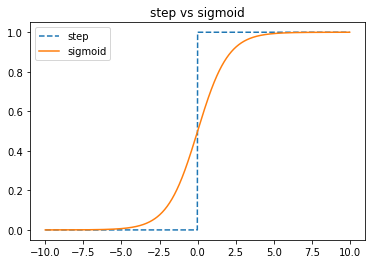

In [65]:
z = [zi/50 - 10 for zi in range(1000)]
plt.plot(z, [step_function(zi) for zi in z], '--', label='step')
plt.plot(z, [sigmoid(zi) for zi in z], label='sigmoid')
plt.title('step vs sigmoid')
plt.legend()
plt.show()

In [66]:
def neuron_output(weights, inputs):
    return sigmoid(dot(weights, inputs))

In [70]:
def feed_forward(neural_network, input_vector):
    """takes in a neural network (represented as a list of lists of lists of weights)
    and returns the output from forward-propagating the input"""
    
    outputs = []
    
    for layer in neural_network:
        input_with_bias = input_vector + [1]
        output = [neuron_output(neuron, input_with_bias)
                  for neuron in layer]
        outputs.append(output)
        
        # the input to the next layer is the output of this one
        input_vector = output
    
    return outputs

In [71]:
xor_network = [
    [[20, 20, -30], [20, 20, -10]],
    [[-60, 60, -30]]
]

In [74]:
outputs = feed_forward(xor_network,[0, 1])
outputs

[[4.5397868702434395e-05, 0.9999546021312976], [0.9999999999999059]]

In [72]:
for x in [0,1]:
    for y in [0,1]:
        print(x, y, feed_forward(xor_network,[x, y])[-1])

0 0 [9.38314668300676e-14]
0 1 [0.9999999999999059]
1 0 [0.9999999999999059]
1 1 [9.383146683006828e-14]


## Backpropagation

In [90]:
def backpropagate(network, input_vector, targets):
    """
    Adjust the weights in the network in place based on a single
    labeled training example.
    """
    hidden_outputs, outputs = feed_forward(network, input_vector)
    
    # the output * (1 - output) is from the derivative of sigmoid
    output_deltas = [output * (1 - output) * (output - target)
                     for output, target in zip(outputs, targets)]
    
    # adjust weights for output layer, one neuron at a time
    for i, output_neuron in enumerate(network[-1]):

        # focus on the ith output layer neuron
        for j, hidden_output in enumerate(hidden_outputs + [1]):

            # adjust the jth weight based on both
            # this neuron's delta and its jth input
            output_neuron[j] -= output_deltas[i] * hidden_output
    
    # back-propagate errors to hidden layer
    hidden_deltas = [hidden_output * (1 - hidden_output) *
                         dot(output_deltas, [n[i] for n in network[-1]])
                     for i, hidden_output in enumerate(hidden_outputs)]

    # adjust weights for hidden layer, one neuron at a time
    for i, hidden_neuron in enumerate(network[0]):
        for j, input in enumerate(input_vector + [1]):
            hidden_neuron[j] -= hidden_deltas[i] * input

### train XOR

randomly initialize

In [108]:
nn = [
    [[random.normalvariate(0, 1/3), random.normalvariate(0, 1/3), random.normalvariate(0, 1/3)],
     [random.normalvariate(0, 1/3), random.normalvariate(0, 1/3), random.normalvariate(0, 1/3)]],
    [[random.normalvariate(0, 1/3), random.normalvariate(0, 1/3), random.normalvariate(0, 1/3)]]
]

train network

In [109]:
training_set = [
    [[0,0], [0]],
    [[0,1], [1]],
    [[1,0], [1]],
    [[1,1], [0]]    
]

In [110]:
for _ in range(10000):
    for input_vector, targets in random.sample(training_set, len(training_set)):
        backpropagate(nn, input_vector, targets)

In [111]:
nn

[[[6.852486545259151, 6.844744503980517, -3.0829434118452386],
  [4.800550076303837, 4.798830831589406, -7.362214269943774]],
 [[10.277322570253569, -11.027195252727264, -4.769477585907083]]]

Predict

In [112]:
for input_vector, targets in training_set:
    output = feed_forward(nn, input_vector)
    print(input_vector, output[-1])

[0, 0] [0.013045785171948064]
[0, 1] [0.9888555179079053]
[1, 0] [0.9888610229899293]
[1, 1] [0.011476679784703119]


...it works!

## Example: Defeating a CAPTCHA

In [113]:
raw_digits = [
      """11111
         1...1
         1...1
         1...1
         11111""",

      """..1..
         ..1..
         ..1..
         ..1..
         ..1..""",

      """11111
         ....1
         11111
         1....
         11111""",

      """11111
         ....1
         11111
         ....1
         11111""",

      """1...1
         1...1
         11111
         ....1
         ....1""",

      """11111
         1....
         11111
         ....1
         11111""",

      """11111
         1....
         11111
         1...1
         11111""",

      """11111
         ....1
         ....1
         ....1
         ....1""",

      """11111
         1...1
         11111
         1...1
         11111""",

      """11111
         1...1
         11111
         ....1
         11111"""]

In [115]:
def make_digit(raw_digit):
    return [1 if c == '1' else 0
            for row in raw_digit.split("\n")
            for c in row.strip()]

In [116]:
inputs = [make_digit(digit) for digit in raw_digits]

In [119]:
# one-hot encode digits 0-9
targets = [[1 if i == j else 0 for i in range(10)] for j in range(10)]

In [120]:
random.seed(0)     # to get repeatable results
input_size = 25    # each input is a vector of length 25
num_hidden = 5     # we'll have 5 neurons in the hidden layer
output_size = 10   # we need 10 outputs for each input

#### Randomly initialize weights

In [125]:
# each hidden neuron has one weight per input, plus a bias weight
hidden_layer = [[random.random() for _ in range(input_size + 1)]
                for _ in range(num_hidden)]

In [126]:
# each output neuron has one weight per hidden neuron, plus a bias weight
output_layer = [[random.random() for _ in range(num_hidden + 1)]
                for _ in range(output_size)]

In [127]:
# the network starts out with random weights
network = [hidden_layer, output_layer]

In [128]:
for _ in range(10000):
    for input_vector, target_vector in zip(inputs, targets):
        backpropagate(network, input_vector, target_vector)

In [129]:
def predict(input):
    return feed_forward(network, input)[-1]

In [130]:
predict(inputs[7])

[5.2035522857413614e-05,
 0.020862455351900053,
 2.812903309033101e-07,
 2.2923594408208606e-06,
 0.020764372534513076,
 0.006641626365941587,
 5.6989438413772215e-08,
 0.9754815819630543,
 1.626487803983827e-10,
 3.1620719281524298e-09]

In [131]:
predict([0,1,1,1,0,
         0,0,0,1,1,
         0,0,1,1,0,
         0,0,0,1,1,
         0,1,1,1,0])

[9.855052202393462e-10,
 4.2151984009455363e-07,
 0.0033689567022900163,
 0.07367084084773357,
 2.0159888024184375e-11,
 2.110925157804927e-08,
 6.992690466039201e-08,
 5.235150186908081e-12,
 0.00014025886808217573,
 0.8717935776034405]

In [132]:
predict([0,1,1,1,0, # .@@@.
         1,0,0,1,1, # @..@@
         0,1,1,1,0, # .@@@.
         1,0,0,1,1, # @..@@
         0,1,1,1,0]) # .@@@.

[1.1742291013485472e-07,
 4.199038107147028e-10,
 0.0003420858239075306,
 0.00050779062878063,
 1.889100537078678e-08,
 1.8234308342580453e-09,
 2.533342673786317e-05,
 2.8234287219557264e-12,
 0.32302464479138926,
 0.9025809898032499]

In [156]:
import matplotlib

In [157]:
def patch(x, y, hatch, color):
    """
    return a matplotlib 'patch' object with the specified
    location, crosshatch pattern, and color
    """
    return matplotlib.patches.Rectangle((x - 0.5, y - 0.5),
                                        1, 1,
                                        hatch=hatch,
                                        fill=False,
                                        color=color)

In [165]:
len(network[0])

5

#### Show weights on 1st neuron

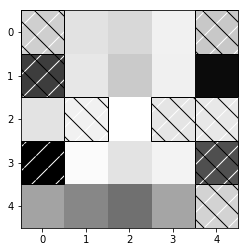

In [188]:
weights = network[0][0]
abs_weights = [abs(w) for w in weights]

grid = [abs_weights[row:(row+5)] for row in range(0,25,5)]

ax = plt.gca()
ax.imshow(grid,
          cmap=matplotlib.cm.binary,
          interpolation='none')

# cross-hatch the negative weights
for i in range(5):
    for j in range(5):
        if weights[5*i + j] < 0:
            ax.add_patch(patch(j, i, '/', "white"))
            ax.add_patch(patch(j, i, '\\', "black"))

plt.show()

#### Draw whole hidden layer

<Figure size 432x288 with 0 Axes>

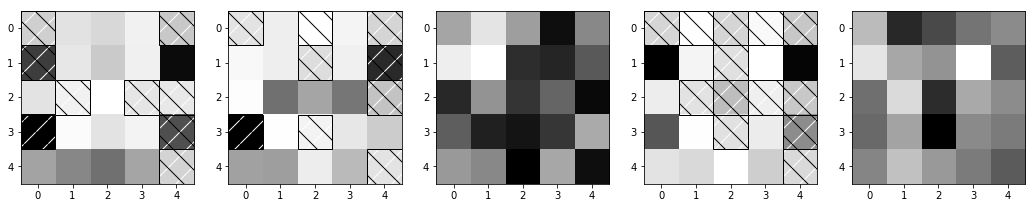

In [187]:
plt.subplots_adjust(wspace=0.5)
fig, ax = plt.subplots(figsize=(18, 10))

for k in range(len(network[0])):
    weights = network[0][k]
    abs_weights = [abs(w) for w in weights]

    grid = [abs_weights[row:(row+5)] for row in range(0,25,5)]

    ax=plt.subplot(1, 5, k+1)
    plt.gca().set_xticks([0,1,2,3,4])
    plt.gca().set_yticks([0,1,2,3,4])
    ax.imshow(grid,
              cmap=matplotlib.cm.binary,
              interpolation='none')

    # cross-hatch the negative weights
    for i in range(5):
        for j in range(5):
            if weights[5*i + j] < 0:
                ax.add_patch(patch(j, i, '/', "white"))
                ax.add_patch(patch(j, i, '\\', "black"))

plt.show()

#### Show hidden layer weights in color

<Figure size 432x288 with 0 Axes>

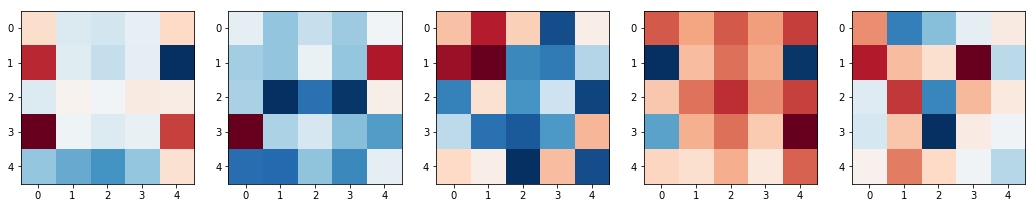

In [195]:
plt.subplots_adjust(wspace=0.5)
fig, ax = plt.subplots(figsize=(18, 10))

for k in range(len(network[0])):
    weights = network[0][k]

    grid = [weights[row:(row+5)] for row in range(0,25,5)]

    ax=plt.subplot(1, 5, k+1)
    plt.gca().set_xticks([0,1,2,3,4])
    plt.gca().set_yticks([0,1,2,3,4])
    ax.imshow(grid,
              cmap=matplotlib.cm.RdBu,
              interpolation='none')

plt.show()

#### Try not-previously-seen inputs

In [196]:
left_column_only = [1, 0, 0, 0, 0] * 5
print(feed_forward(network, left_column_only)[0][0])

1.614430903007115e-05


In [197]:
center_middle_row=[0,0,0,0,0]*2+[0,1,1,1,0]+[0,0,0,0,0]*2
print(feed_forward(network, center_middle_row)[0][0])

0.181709338346295


In [198]:
right_column_only = [0, 0, 0, 0, 1] * 5
print(feed_forward(network, right_column_only)[0][0])

0.1258375855599754
